#Architecture 1 DEAP DATA SET - MSDCGT - Emotion Classification(Detection)

# Imports & Libraries

In [ ]:
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = '/content/drive/MyDrive/EEG2 - Copy/data_preprocessed_python'
else:
    DATA_DIR = './data_preprocessed_python'

FS = 128
N_EEG_CHANNELS = 32
BASELINE_SEC = 3
BASELINE_SAMPLES = BASELINE_SEC * FS

# EEG Channel Names
EEG_CHANNELS = [
    'Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7',
    'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz',
    'Fp2', 'AF4', 'F4', 'F8', 'FC6', 'FC2', 'C4', 'T8',
    'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2', 'Fz', 'Cz'
]

# 4-Class Names
CLASS_NAMES = ['LVLA', 'LVHA', 'HVLA', 'HVHA']

# Exploratory Data Analysis & Visualizations

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data shape: (32, 40, 40, 8064)
Labels shape: (32, 40, 4)
Subjects:    32
Trials per subject:    40
Channels:    40 (32 EEG + 8 peripheral)
Labels:     4 (Valence, Arousal, Dominance, Liking)

Label Statistics:
       Valence  Arousal  Dominance   Liking
count  1280.00  1280.00    1280.00  1280.00
mean      3.47     3.73       5.38     5.52
std       2.01     1.98       2.10     2.28
min       0.00     0.00       1.00     1.00
25%       1.95     2.06       3.93     3.96
50%       3.08     3.32       5.24     6.05
75%       4.95     4.99       7.04     7.09
max       9.00     9.00       9.00     9.00


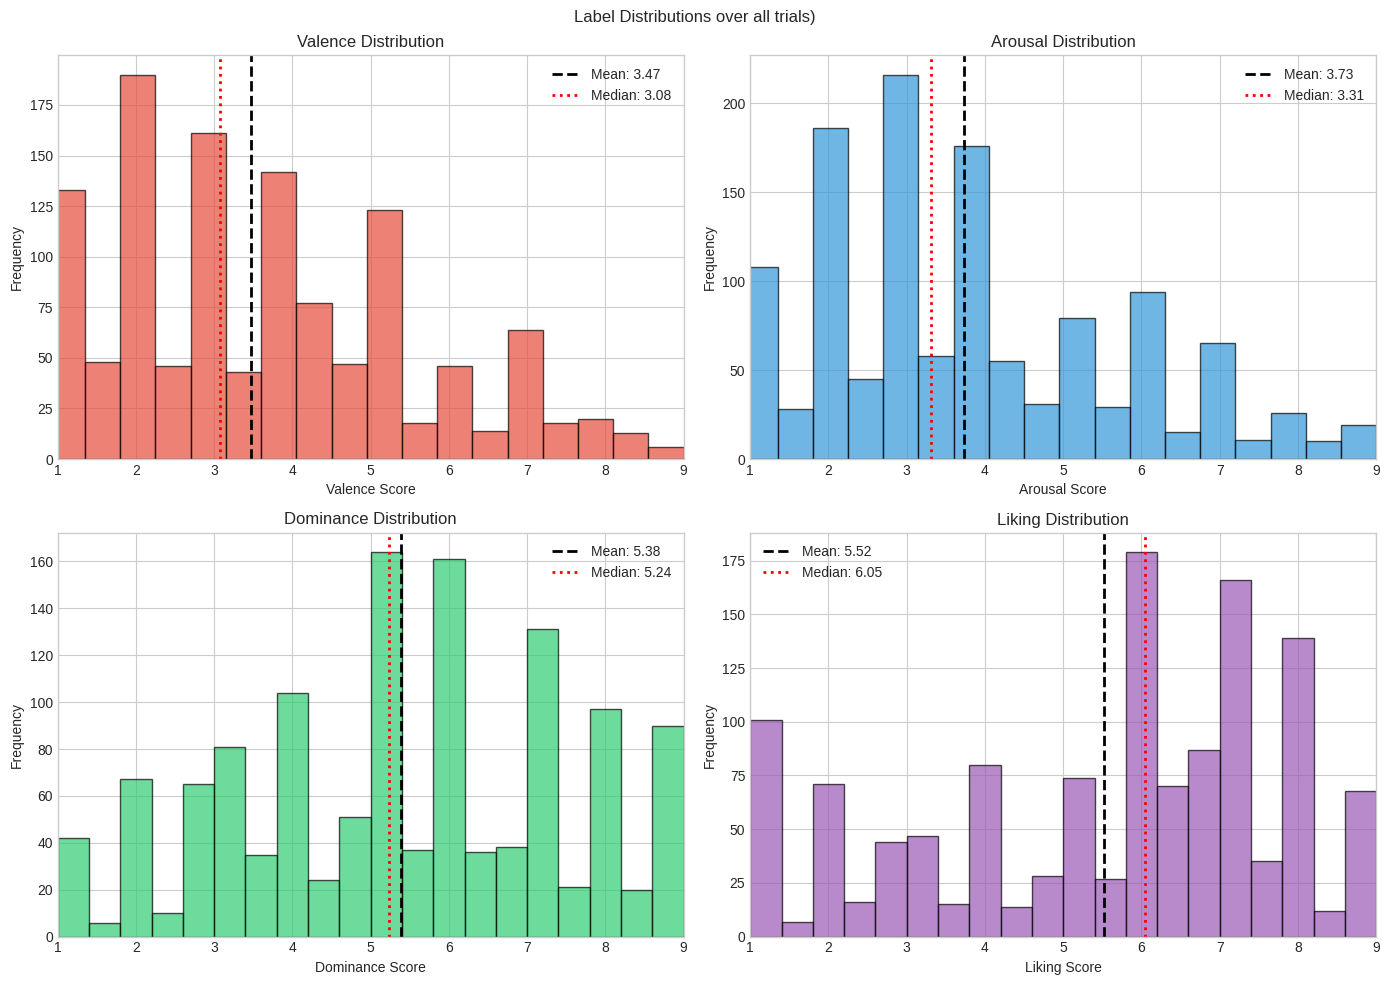

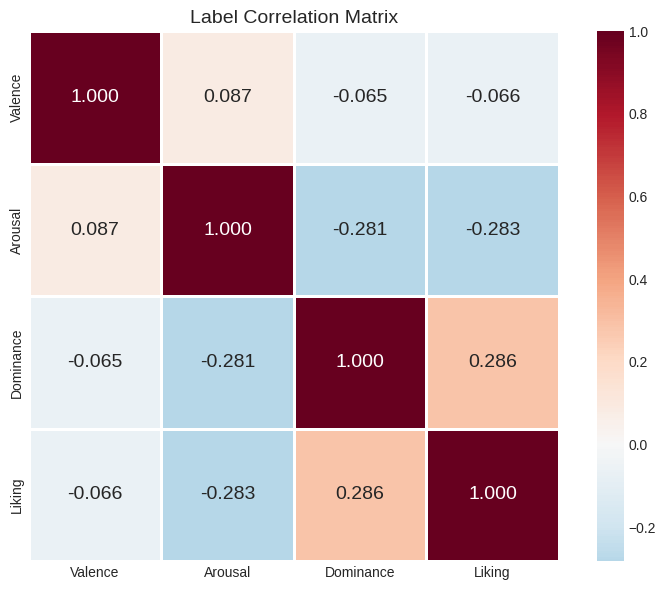

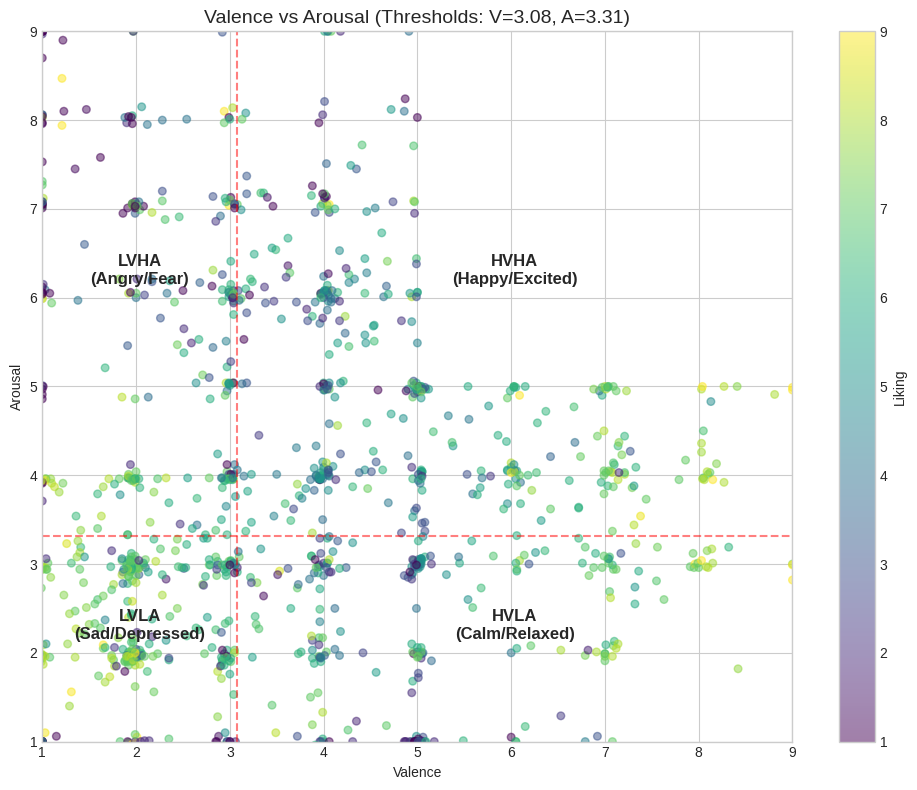

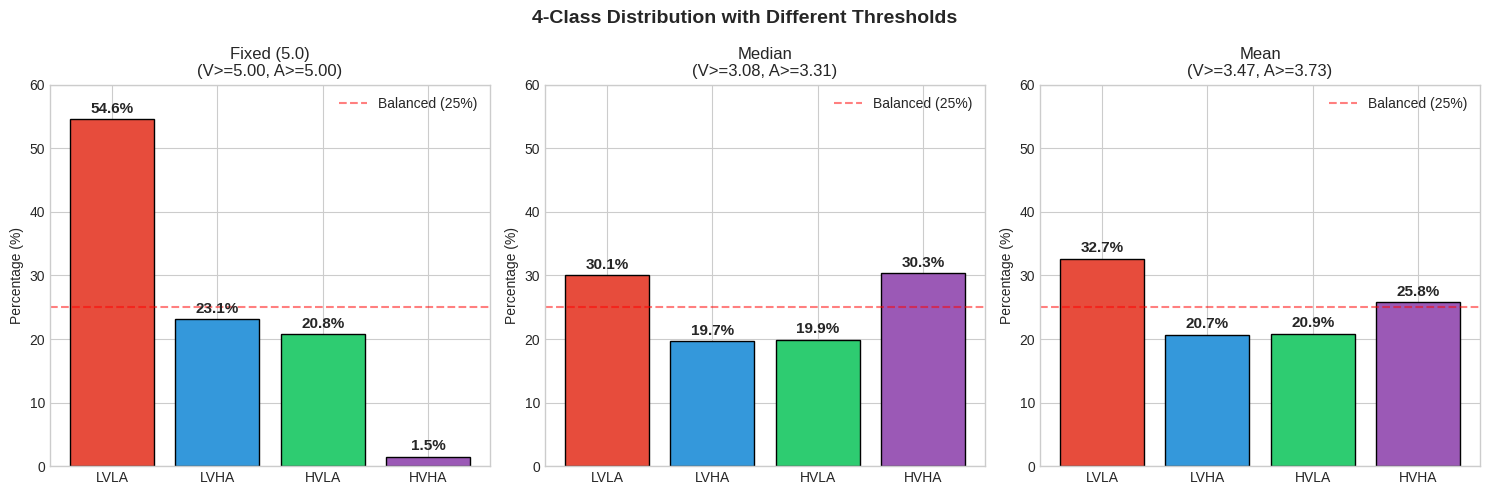

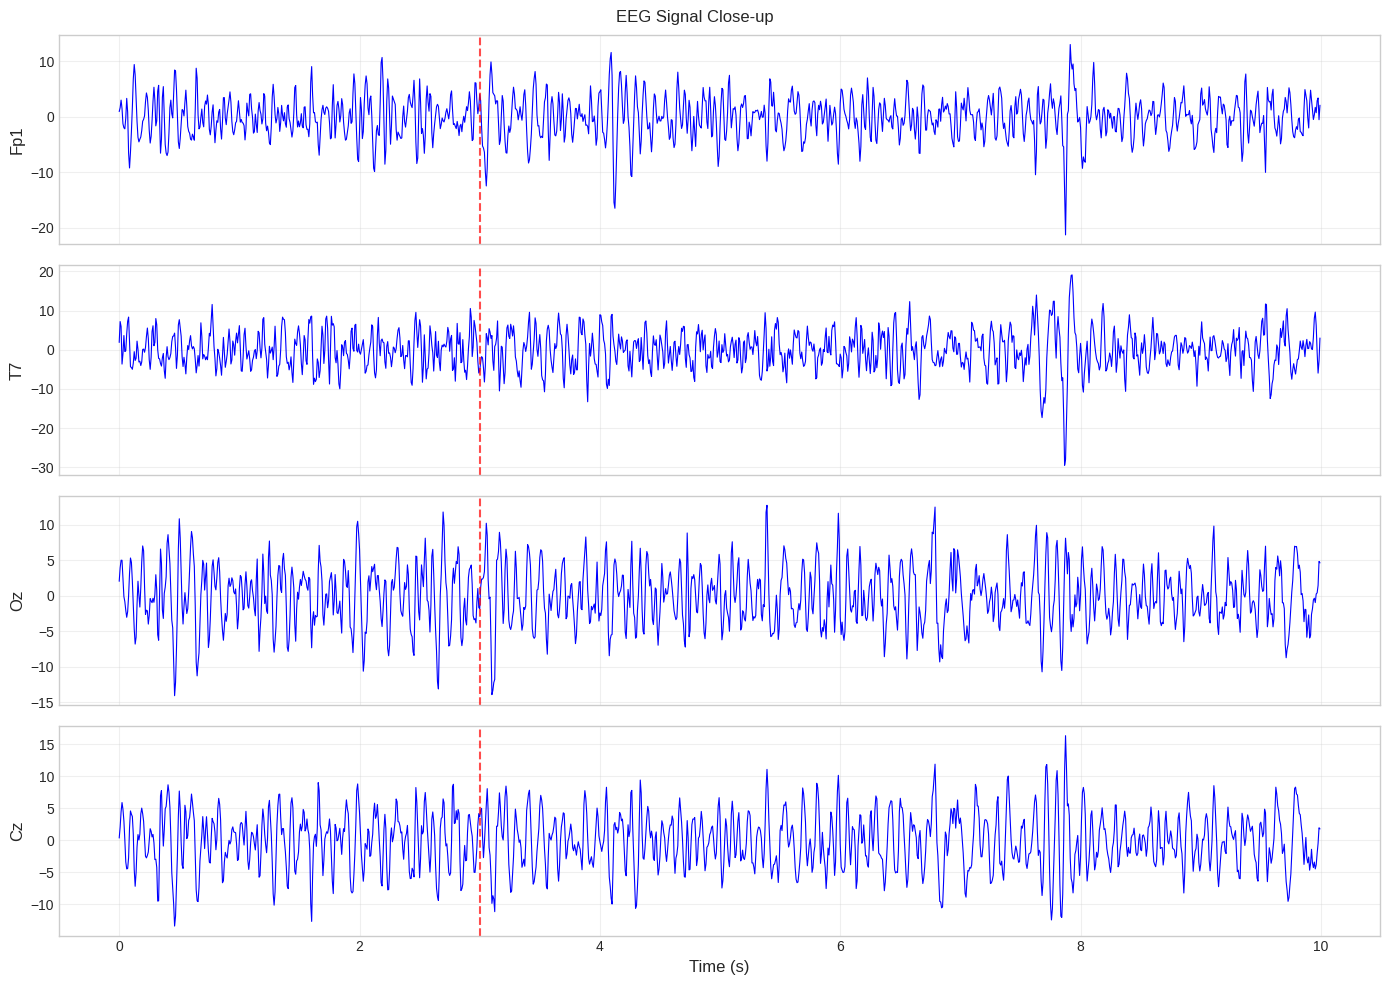

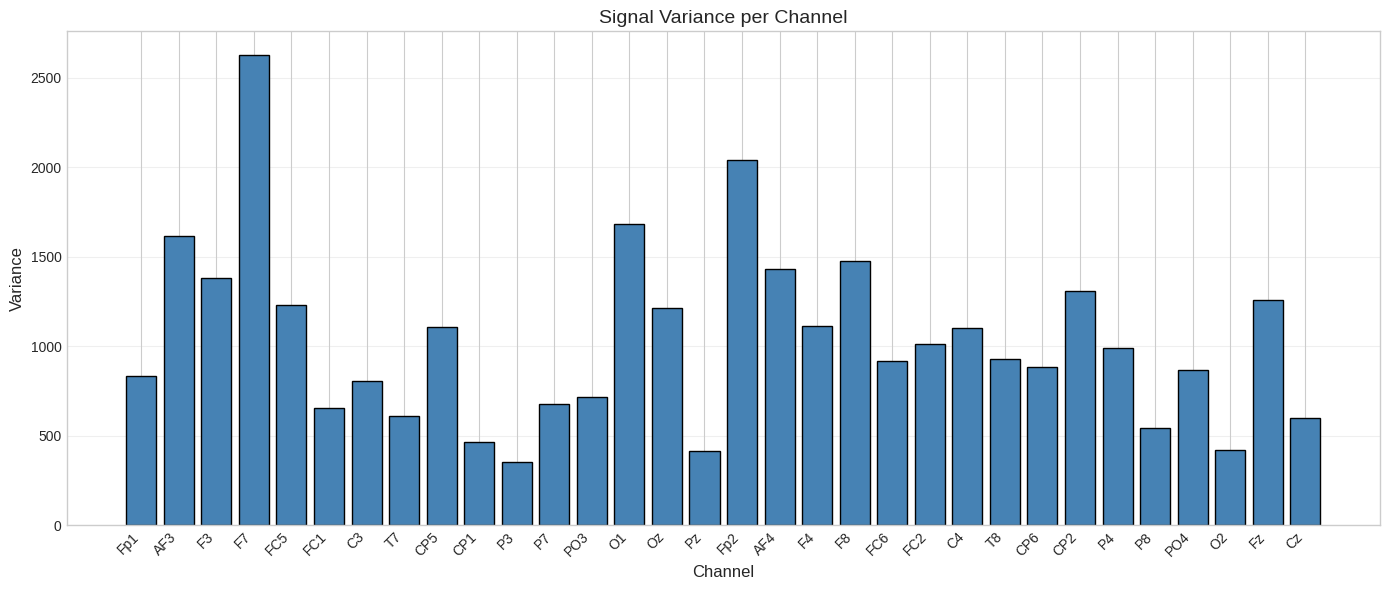

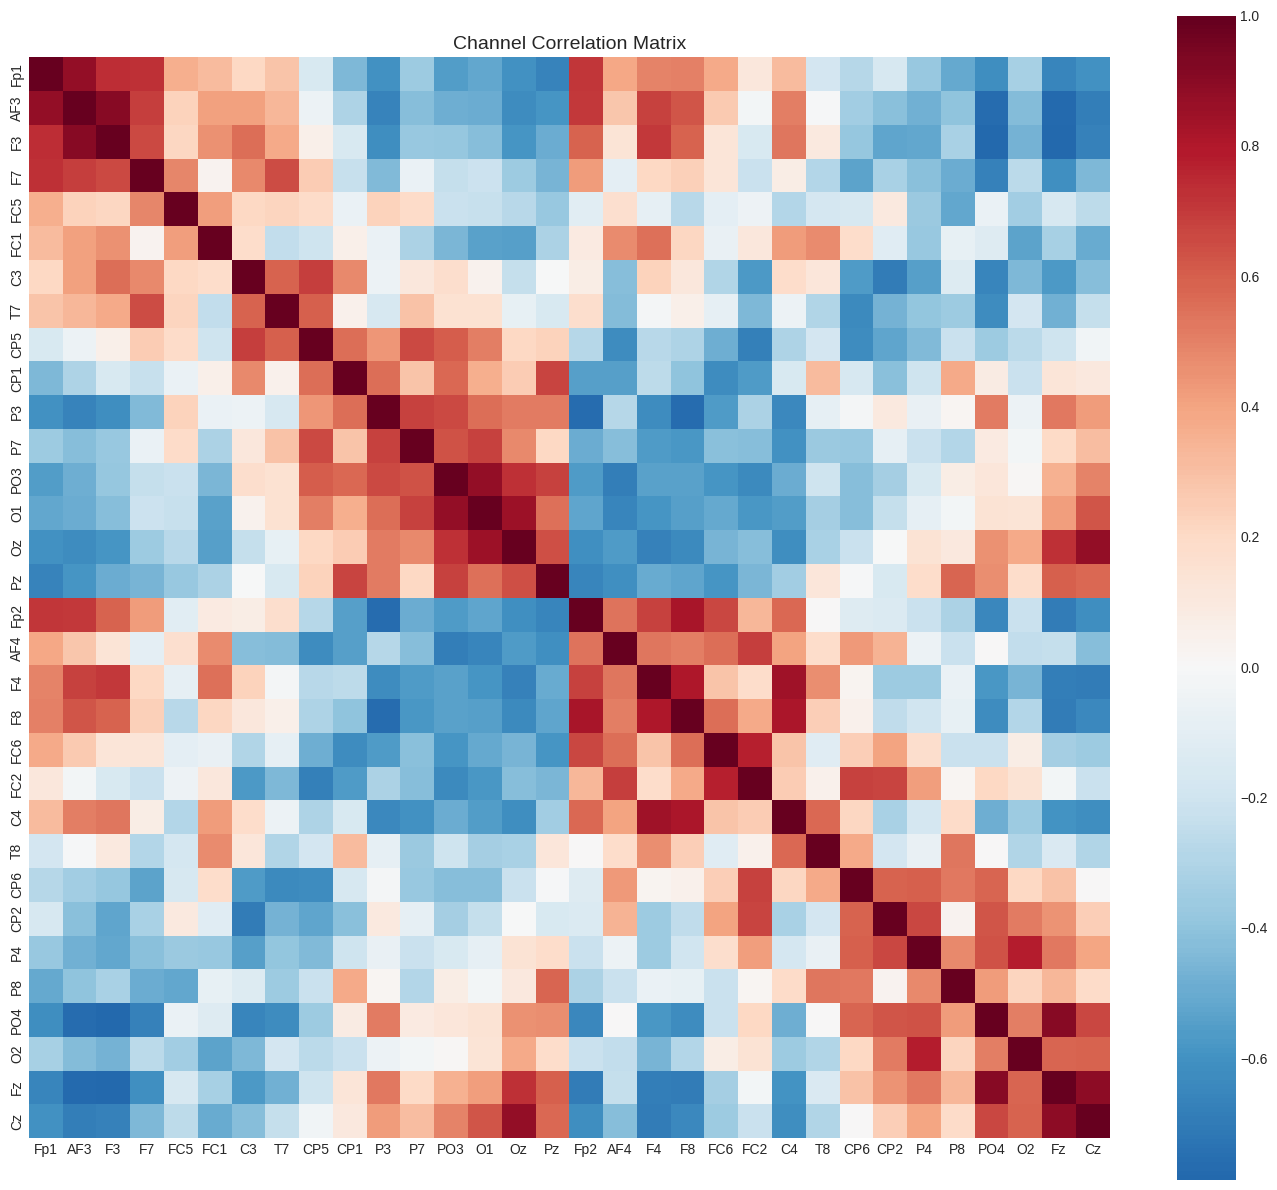

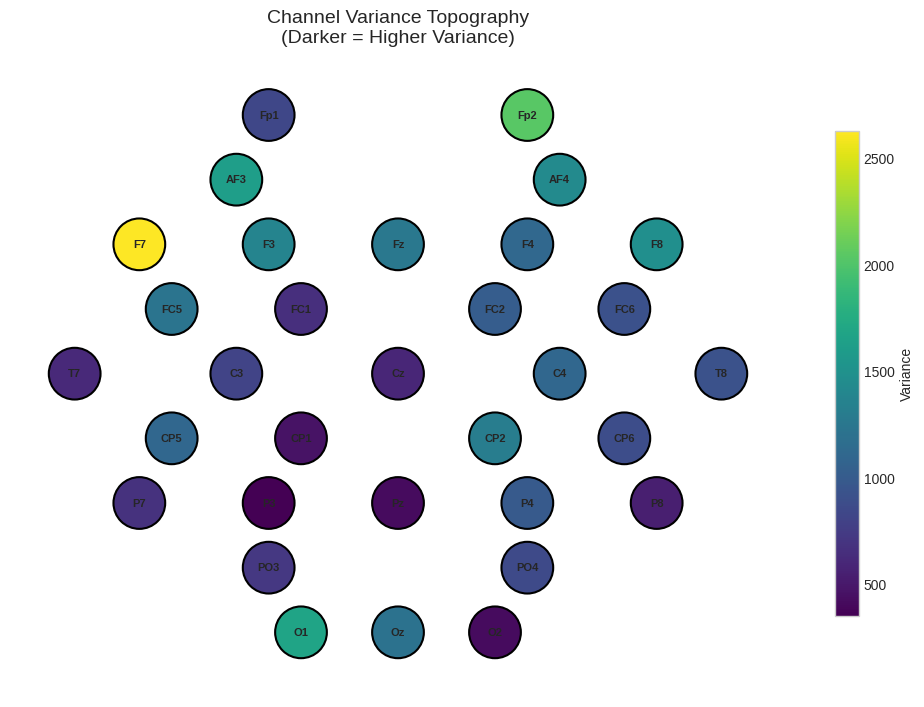

In [ ]:
import pandas as pd
from scipy import signal
from scipy.stats import pearsonr, spearmanr

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# EDA-specific Constants
N_PERIPHERAL_CHANNELS = 8
N_TOTAL_CHANNELS = 40
TRIAL_SEC = 60
TOTAL_SEC = 63
TRIAL_SAMPLES = TRIAL_SEC * FS
TOTAL_SAMPLES = TOTAL_SEC * FS

PERIPHERAL_CHANNELS = ['hEOG', 'vEOG', 'zEMG', 'tEMG', 'GSR', 'Respiration', 'Plethysmograph', 'Temperature']

LABEL_NAMES = ['Valence', 'Arousal', 'Dominance', 'Liking']

FREQ_BANDS = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 45)
}

def load_all_data(data_dir):

    files = sorted([f for f in os.listdir(data_dir) if f.endswith('.dat')])

    all_data = []
    all_labels = []
    subject_ids = []

    for subj_idx, file_name in enumerate(files):
        file_path = os.path.join(data_dir, file_name)

        with open(file_path, 'rb') as f:
            content = pickle.load(f, encoding='latin1')

        data = content['data']
        labels = content['labels']

        all_data.append(data)
        all_labels.append(labels)
        subject_ids.extend([subj_idx] * 40)

    all_data = np.array(all_data)
    all_labels = np.array(all_labels)

    print(f"Data shape: {all_data.shape}")
    print(f"Labels shape: {all_labels.shape}")

    return all_data, all_labels, subject_ids

all_data, all_labels, subject_ids = load_all_data(DATA_DIR)

def dataset_overview(all_data, all_labels):

    n_subjects = all_data.shape[0]
    n_trials = all_data.shape[1]
    n_channels = all_data.shape[2]
    n_samples = all_data.shape[3]

    print(f"Subjects: {n_subjects:>5}\n"
          f"Trials per subject: {n_trials:>5}\n"
          f"Channels: {n_channels:>5} (32 EEG + 8 peripheral)\n"
          f"Labels: {len(LABEL_NAMES):>5} (Valence, Arousal, Dominance, Liking)")

dataset_overview(all_data, all_labels)

def analyze_labels(all_labels):

    labels_flat = all_labels.reshape(-1, 4)

    df = pd.DataFrame(labels_flat, columns=LABEL_NAMES)

    print("\nLabel Statistics:")
    print(df.describe().round(2))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

    for idx, (label, color) in enumerate(zip(LABEL_NAMES, colors)):
        ax = axes[idx // 2, idx % 2]
        ax.hist(df[label], bins=20, color=color, edgecolor='black', alpha=0.7)
        ax.axvline(df[label].mean(), color='black', linestyle='--', linewidth=2, label=f'Mean: {df[label].mean():.2f}')
        ax.axvline(df[label].median(), color='red', linestyle=':', linewidth=2, label=f'Median: {df[label].median():.2f}')
        ax.set_xlabel(f'{label} Score')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{label} Distribution')
        ax.legend()
        ax.set_xlim(1, 9)

    plt.suptitle('Label Distributions over all trials)')
    plt.tight_layout()

    return df

labels_df = analyze_labels(all_labels)

def analyze_label_correlations(labels_df):

    corr_matrix = labels_df.corr()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=2, fmt='.3f', ax=ax,
                annot_kws={'size': 14})
    ax.set_title('Label Correlation Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()

    v_thresh = labels_df['Valence'].median()
    a_thresh = labels_df['Arousal'].median()

    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(labels_df['Valence'], labels_df['Arousal'],
                        c=labels_df['Liking'], cmap='viridis', alpha=0.5, s=30)
    ax.axhline(a_thresh, color='red', linestyle='--', alpha=0.5)
    ax.axvline(v_thresh, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Valence')
    ax.set_ylabel('Arousal')
    ax.set_title(f'Valence vs Arousal (Thresholds: V={v_thresh:.2f}, A={a_thresh:.2f})', fontsize=14)

    ax.text((1 + v_thresh)/2, (a_thresh + 9)/2, 'LVHA\n(Angry/Fear)', ha='center', fontsize=12, fontweight='bold')
    ax.text((v_thresh + 9)/2, (a_thresh + 9)/2, 'HVHA\n(Happy/Excited)', ha='center', fontsize=12, fontweight='bold')
    ax.text((1 + v_thresh)/2, (1 + a_thresh)/2, 'LVLA\n(Sad/Depressed)', ha='center', fontsize=12, fontweight='bold')
    ax.text((v_thresh + 9)/2, (1 + a_thresh)/2, 'HVLA\n(Calm/Relaxed)', ha='center', fontsize=12, fontweight='bold')

    plt.colorbar(scatter, label='Liking')
    ax.set_xlim(1, 9)
    ax.set_ylim(1, 9)
    plt.tight_layout()

analyze_label_correlations(labels_df)

def analyze_4class_distribution(all_labels):

    labels_flat = all_labels.reshape(-1, 4)

    thresholds = {
        'Fixed (5.0)': (5.0, 5.0),
        'Median': (np.median(labels_flat[:, 0]), np.median(labels_flat[:, 1])),
        'Mean': (np.mean(labels_flat[:, 0]), np.mean(labels_flat[:, 1]))
    }

    class_names = ['LVLA', 'LVHA', 'HVLA', 'HVHA']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, (method, (v_thresh, a_thresh)) in enumerate(thresholds.items()):
        high_v = labels_flat[:, 0] >= v_thresh
        high_a = labels_flat[:, 1] >= a_thresh

        classes = np.zeros(len(labels_flat), dtype=int)
        classes[(~high_v) & (~high_a)] = 0
        classes[(~high_v) & (high_a)] = 1
        classes[(high_v) & (~high_a)] = 2
        classes[(high_v) & (high_a)] = 3

        counts = [np.sum(classes == i) for i in range(4)]
        pcts = [100 * c / len(classes) for c in counts]

        colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
        bars = axes[idx].bar(class_names, pcts, color=colors, edgecolor='black')
        for bar, pct in zip(bars, pcts):
            axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                          f'{pct:.1f}%', ha='center', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Percentage (%)')
        axes[idx].set_title(f'{method}\n(V>={v_thresh:.2f}, A>={a_thresh:.2f})')
        axes[idx].set_ylim(0, 60)
        axes[idx].axhline(25, color='red', linestyle='--', alpha=0.5, label='Balanced (25%)')
        axes[idx].legend()

    plt.suptitle('4-Class Distribution with Different Thresholds', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

analyze_4class_distribution(all_labels)

def visualize_eeg_signals(all_data):

    sample_data = all_data[0, 0, :N_EEG_CHANNELS, :]
    time = np.arange(TOTAL_SAMPLES) / FS

    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    sample_channels = [0, 7, 14, 31]

    for ax, ch_idx in zip(axes, sample_channels):
        ch_data = sample_data[ch_idx, :10*FS]
        time_short = np.arange(len(ch_data)) / FS
        ax.plot(time_short, ch_data, linewidth=0.8, color='blue')
        ax.axvline(BASELINE_SEC, color='red', linestyle='--', alpha=0.7)
        ax.set_ylabel(f'{EEG_CHANNELS[ch_idx]}', fontsize=12)
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel('Time (s)', fontsize=12)
    plt.suptitle('EEG Signal Close-up')
    plt.tight_layout()
    plt.show()

visualize_eeg_signals(all_data)

def channel_analysis(all_data):

    eeg_data = all_data[:, :, :N_EEG_CHANNELS, BASELINE_SAMPLES:]

    channel_means = eeg_data.mean(axis=(0, 1, 3))
    channel_stds = eeg_data.std(axis=(0, 1, 3))
    channel_vars = eeg_data.var(axis=(0, 1, 3))

    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(EEG_CHANNELS))
    bars = ax.bar(x, channel_vars, color='steelblue', edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(EEG_CHANNELS, rotation=45, ha='right')
    ax.set_xlabel('Channel', fontsize=12)
    ax.set_ylabel('Variance', fontsize=12)
    ax.set_title('Signal Variance per Channel', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    sample_eeg = all_data[0, 0, :N_EEG_CHANNELS, BASELINE_SAMPLES:]
    corr_matrix = np.corrcoef(sample_eeg)

    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(corr_matrix, xticklabels=EEG_CHANNELS, yticklabels=EEG_CHANNELS,
                cmap='RdBu_r', center=0, ax=ax, square=True)
    ax.set_title('Channel Correlation Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 10))

    positions = {
        'Fp1': (3, 9), 'Fp2': (7, 9),
        'AF3': (2.5, 8), 'AF4': (7.5, 8),
        'F7': (1, 7), 'F3': (3, 7), 'Fz': (5, 7), 'F4': (7, 7), 'F8': (9, 7),
        'FC5': (1.5, 6), 'FC1': (3.5, 6), 'FC2': (6.5, 6), 'FC6': (8.5, 6),
        'T7': (0, 5), 'C3': (2.5, 5), 'Cz': (5, 5), 'C4': (7.5, 5), 'T8': (10, 5),
        'CP5': (1.5, 4), 'CP1': (3.5, 4), 'CP2': (6.5, 4), 'CP6': (8.5, 4),
        'P7': (1, 3), 'P3': (3, 3), 'Pz': (5, 3), 'P4': (7, 3), 'P8': (9, 3),
        'PO3': (3, 2), 'PO4': (7, 2),
        'O1': (3.5, 1), 'Oz': (5, 1), 'O2': (6.5, 1)
    }

    norm_vars = (channel_vars - channel_vars.min()) / (channel_vars.max() - channel_vars.min())

    for i, ch in enumerate(EEG_CHANNELS):
        if ch in positions:
            x, y = positions[ch]
            color = plt.cm.viridis(norm_vars[i])
            circle = plt.Circle((x, y), 0.4, color=color, ec='black', linewidth=1.5)
            ax.add_patch(circle)
            ax.text(x, y, ch, ha='center', va='center', fontsize=8, fontweight='bold')

    ax.set_xlim(-1, 11)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Channel Variance Topography\n(Darker = Higher Variance)', fontsize=14)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(channel_vars.min(), channel_vars.max()))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Variance', shrink=0.5)

    plt.tight_layout()
    plt.show()

channel_analysis(all_data)

#Model Training

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
Loading 32 files...
Thresholds: V=3.08, A=3.31
Data: (38400, 32, 256), Labels: (38400,)
  LVLA: 11550 (30.1%)
  LVHA: 7560 (19.7%)
  HVLA: 7650 (19.9%)
  HVHA: 11640 (30.3%)

Train: 30720, Test: 7680

Training
Epoch  1/350 | Loss: 1.328/1.273 | Acc: 36.2%/41.8% | F1: 41.5%
Epoch  2/350 | Loss: 1.244/1.241 | Acc: 43.7%/43.5% | F1: 43.3%
Epoch  3/350 | Loss: 1.222/1.225 | Acc: 44.5%/44.1% | F1: 43.6%
Epoch  4/350 | Loss: 1.213/1.224 | Acc: 45.1%/44.9% | F1: 44.4%
Epoch  5/350 | Loss: 1.204/1.217 | Acc: 45.6%/45.3% | F1: 44.6%
Epoch  6/350 | Loss: 1.198/1.222 | Acc: 45.9%/45.2% | F1: 44.5%
Epoch  7/350 | Loss: 1.195/1.210 | Acc: 46.4%/45.3% | F1: 44.6%
Epoch  8/350 | Loss: 1.190/1.209 | Acc: 46.7%/45.5% | F1: 44.7%
Epoch  9/350 | Loss: 1.186/1.204 | Acc: 46.8%/45.8% | F1: 44.8%
Epoch 10/350 | Loss: 1.181/1.206 | Acc: 46.9%/46.0% | F1: 45.2%
Epoch 11

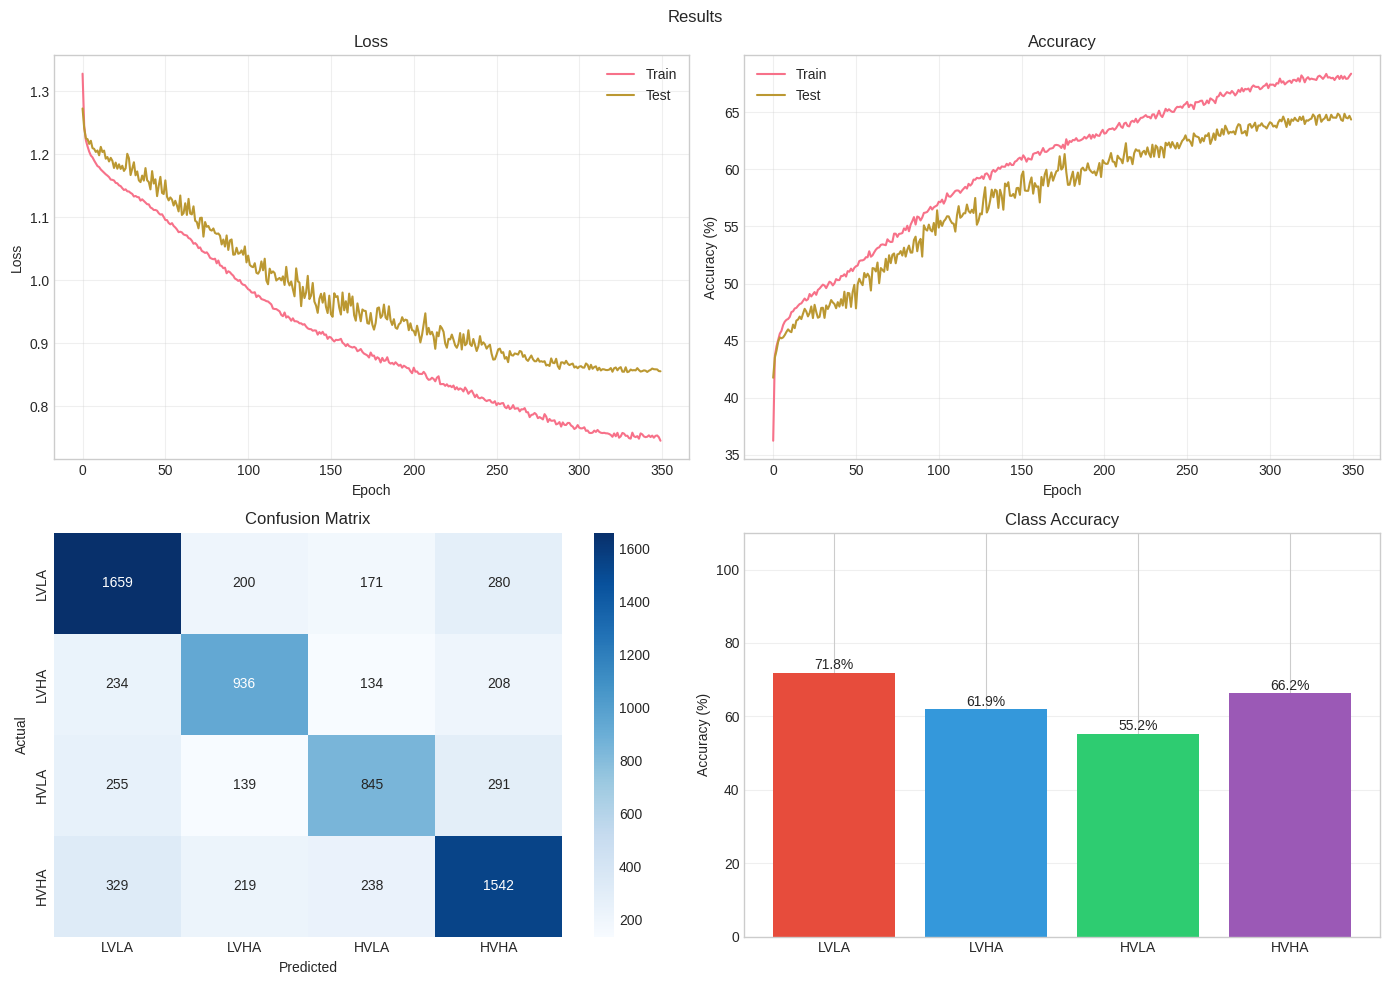


Model saved to: /content/drive/MyDrive/EEG2 - Copy/results/msdcgt_classification_model.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

N_CHANNELS = N_EEG_CHANNELS
N_CLASSES = 4

BATCH_SIZE = 128
EPOCHS = 350
LEARNING_RATE = 3e-4
SEGMENT_SEC = 2
SEGMENT_SAMPLES = SEGMENT_SEC * FS

# Data Loading
def get_4class_label(valence, arousal, v_thresh, a_thresh):
    high_v = valence >= v_thresh
    high_a = arousal >= a_thresh
    if not high_v and not high_a:
        return 0
    elif not high_v and high_a:
        return 1
    elif high_v and not high_a:
        return 2
    else:
        return 3

def load_deap_4class(data_dir, segment_samples=256):
    files = sorted([f for f in os.listdir(data_dir) if f.endswith('.dat')])
    print(f"Loading {len(files)} files...")

    # Thresholds
    all_v, all_a = [], []
    for f in files:
        with open(os.path.join(data_dir, f), 'rb') as file:
            content = pickle.load(file, encoding='latin1')
        all_v.extend(content['labels'][:, 0])
        all_a.extend(content['labels'][:, 1])

    v_thresh, a_thresh = np.median(all_v), np.median(all_a)
    print(f"Thresholds: V={v_thresh:.2f}, A={a_thresh:.2f}")

    all_X, all_y = [], []
    for file_name in files:
        with open(os.path.join(data_dir, file_name), 'rb') as f:
            content = pickle.load(f, encoding='latin1')

        data = content['data'][:, :N_CHANNELS, BASELINE_SAMPLES:]
        labels = content['labels']

        for trial_idx in range(data.shape[0]):
            trial_data = data[trial_idx]
            v, a = labels[trial_idx, 0], labels[trial_idx, 1]
            class_label = get_4class_label(v, a, v_thresh, a_thresh)

            n_segments = trial_data.shape[1] // segment_samples
            for seg_idx in range(n_segments):
                start = seg_idx * segment_samples
                segment = trial_data[:, start:start + segment_samples]
                segment = (segment - segment.mean()) / (segment.std() + 1e-8)
                all_X.append(segment)
                all_y.append(class_label)

    X = np.array(all_X, dtype=np.float32)
    y = np.array(all_y, dtype=np.int64)

    print(f"Data: {X.shape}, Labels: {y.shape}")
    for i, name in enumerate(CLASS_NAMES):
        print(f"  {name}: {np.sum(y==i)} ({100*np.mean(y==i):.1f}%)")

    return X, y

class DEAPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Model
class MultiScaleCNN(nn.Module):
    def __init__(self, n_channels=32):
        super().__init__()
        n_filters = 8

        def make_branch(k):
            return nn.Sequential(
                nn.Conv2d(1, n_filters, (1, k), padding=(0, k//2)),
                nn.BatchNorm2d(n_filters), nn.ELU(),
                nn.Conv2d(n_filters, n_filters, (n_channels, 1)),
                nn.BatchNorm2d(n_filters), nn.ELU(),
                nn.AvgPool2d((1, 4)), nn.Dropout(0.4)
            )

        self.branch1 = make_branch(16)
        self.branch2 = make_branch(8)
        self.branch3 = make_branch(4)

    def forward(self, x):
        x = x.unsqueeze(1)
        b1 = self.branch1(x).squeeze(2)
        b2 = self.branch2(x).squeeze(2)
        b3 = self.branch3(x).squeeze(2)
        return torch.cat([b1, b2, b3], dim=1)


class MSDCGTNet_Fast(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        self.ms_cnn = MultiScaleCNN()

        # Transformer
        self.attn = nn.MultiheadAttention(24, 8, batch_first=True, dropout=0.1)
        self.norm = nn.LayerNorm(24)
        self.mlp = nn.Sequential(nn.Linear(24, 96), nn.GELU(), nn.Linear(96, 24))

        # TCN
        self.tcn = nn.Sequential(
            nn.Conv1d(24, 32, 3, padding=1), nn.BatchNorm1d(32), nn.ELU(),
            nn.Conv1d(32, 32, 3, padding=2, dilation=2), nn.BatchNorm1d(32), nn.ELU()
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.ms_cnn(x)
        x = x.transpose(1, 2)
        x = self.norm(x + self.attn(x, x, x)[0])
        x = x + self.mlp(x)
        x = x.transpose(1, 2)
        x = self.tcn(x)
        x = self.pool(x).squeeze(-1)
        return self.classifier(x)

# Training Functions
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
            logits = model(X)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, pred = logits.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()

    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            total_loss += loss.item()
            _, pred = logits.max(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    preds, labels = np.array(all_preds), np.array(all_labels)
    acc = 100. * accuracy_score(labels, preds)
    f1 = 100. * f1_score(labels, preds, average='weighted')

    return total_loss / len(loader), acc, f1, preds, labels

# Plots
def plot_results(history, preds, labels, save_dir='.'):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train')
    axes[0, 0].plot(history['test_loss'], label='Test')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train')
    axes[0, 1].plot(history['test_acc'], label='Test')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')
    axes[1, 0].set_title('Confusion Matrix')

    # Class Accuracy
    class_acc = cm.diagonal() / cm.sum(axis=1) * 100
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
    bars = axes[1, 1].bar(CLASS_NAMES, class_acc, color=colors)
    for bar, acc in zip(bars, class_acc):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{acc:.1f}%', ha='center', fontsize=10)
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('Class Accuracy')
    axes[1, 1].set_ylim(0, 110)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    plt.suptitle('Results')
    plt.tight_layout()
    plt.show()

# Main
def main():
    X, y = load_deap_4class(DATA_DIR, SEGMENT_SAMPLES)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )
    print(f"\nTrain: {len(X_train)}, Test: {len(X_test)}")

    # Loaders
    train_loader = DataLoader(DEAPDataset(X_train, y_train),
                              batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2, pin_memory=True)
    test_loader = DataLoader(DEAPDataset(X_test, y_test),
                             batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=2, pin_memory=True)

    # Model
    model = MSDCGTNet_Fast(N_CLASSES).to(device)

    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE*10,
                                               total_steps=EPOCHS, pct_start=0.3)
    scaler = GradScaler('cuda' if device.type == 'cuda' else 'cpu')

    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    best_acc = 0

    print("\nTraining")
    print("======================================================================")
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
        test_loss, test_acc, test_f1, preds, labels = evaluate(model, test_loader, criterion, device)
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            best_state = model.state_dict().copy()
            best_preds, best_labels = preds, labels

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.3f}/{test_loss:.3f} | "
              f"Acc: {train_acc:.1f}%/{test_acc:.1f}% | F1: {test_f1:.1f}%")

    print("======================================================================")

    print(f"Best Accuracy: {best_acc:.2f}%")

    print("\nClassification Report:")
    print(classification_report(best_labels, best_preds, target_names=CLASS_NAMES))

    # Plot
    plot_results(history, best_preds, best_labels)

    return best_acc


if __name__ == "__main__":
    acc = main()

# Architecture 2 - BCI Competition IV-2a - Motor Stimulus detection

Dataset loading

In [ ]:
import subprocess
from scipy.signal import resample
import os

# BCI Dataset Constants
BCI_FS = 250
BCI_N_CHANNELS = 22
BCI_SEGMENT_SAMPLES = 256

BCI_CHANNELS = [
    'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3',
    'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz',
    'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz'
]

BCI_CLASS_NAMES = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']

# Download dataset
BCI_DATA_DIR = '/content/bcidatasetIV2a'
if not os.path.exists(BCI_DATA_DIR):
    print("Downloading BCI dataset...")
    subprocess.run(['git', 'clone', 'https://github.com/bregydoc/bcidatasetIV2a.git', BCI_DATA_DIR], check=True)
    print("Done!")
else:
    print(f"BCI dataset exists at {BCI_DATA_DIR}")

bci_files = sorted([f for f in os.listdir(BCI_DATA_DIR) if f.endswith('.npz')])
print(f"Found {len(bci_files)} files")

BCI dataset exists at /content/bcidatasetIV2a
Found 18 files


Dataset unpacking

In [ ]:
import numpy as np

# BCI Dataset Constants
BCI_FS = 250
BCI_N_CHANNELS = 22
BCI_SEGMENT_SAMPLES = 256

BCI_CHANNELS = [
    'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3',
    'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz',
    'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz'
]

BCI_CLASS_NAMES = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']

def load_bci_raw(data_dir):
    files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npz')])

    all_trials = []
    all_labels = []
    subject_ids = []

    mi_codes = {769: 0, 770: 1, 771: 2, 772: 3}

    for file_name in files:
        subj_id = file_name[:3]
        data = np.load(os.path.join(data_dir, file_name))

        signal = data['s']
        etyp = data['etyp'].flatten()
        epos = data['epos'].flatten()

        start_indices = np.where(etyp == 768)[0]

        for idx in start_indices:
            try:
                next_event = etyp[idx + 1]
                if next_event not in mi_codes:
                    continue

                trial_start = epos[idx]
                mi_start = trial_start + int(3 * BCI_FS)
                mi_end = trial_start + int(7 * BCI_FS)

                trial_data = signal[mi_start:mi_end, :BCI_N_CHANNELS].T

                if trial_data.shape[1] >= 1000:
                    all_trials.append(trial_data)
                    all_labels.append(mi_codes[next_event])
                    subject_ids.append(subj_id)
            except:
                continue

    return all_trials, all_labels, subject_ids

bci_trials, bci_labels, bci_subjects = load_bci_raw(BCI_DATA_DIR)
print(f"Total trials: {len(bci_trials)}")
print(f"Trial shape: {bci_trials[0].shape}")
print(f"Unique subjects: {len(set(bci_subjects))}")

Total trials: 2328
Trial shape: (22, 1000)
Unique subjects: 9


EDA on Dataset

Subjects: 9
Total trials: 2328
Channels: 22
Sampling rate: 250 Hz
Trial duration: 4 seconds (motor imagery period)

Class Distribution:
  Left Hand: 572 (24.6%)
  Right Hand: 591 (25.4%)
  Feet: 574 (24.7%)
  Tongue: 591 (25.4%)


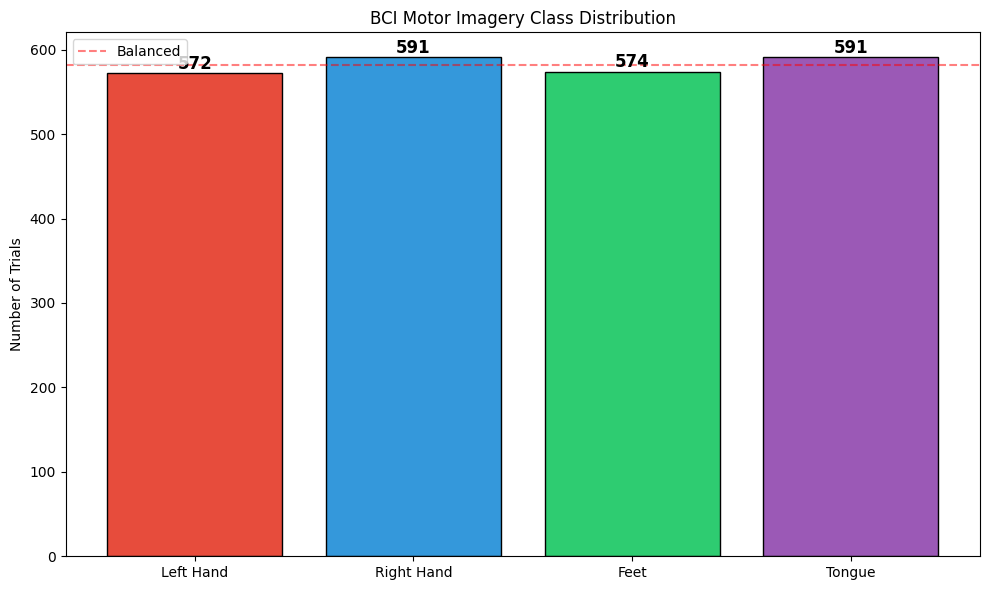

In [ ]:
import matplotlib.pyplot as plt

print(f"Subjects: {len(set(bci_subjects))}")
print(f"Total trials: {len(bci_trials)}")
print(f"Channels: {BCI_N_CHANNELS}")
print(f"Sampling rate: {BCI_FS} Hz")
print(f"Trial duration: 4 seconds (motor imagery period)")

labels_array = np.array(bci_labels)
print("\nClass Distribution:")
for i, name in enumerate(BCI_CLASS_NAMES):
    count = np.sum(labels_array == i)
    pct = 100 * count / len(labels_array)
    print(f"  {name}: {count} ({pct:.1f}%)")

fig, ax = plt.subplots(figsize=(10, 6))
counts = [np.sum(labels_array == i) for i in range(4)]
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
bars = ax.bar(BCI_CLASS_NAMES, counts, color=colors, edgecolor='black')
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{count}', ha='center', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Trials')
ax.set_title('BCI Motor Imagery Class Distribution')
ax.axhline(len(labels_array)/4, color='red', linestyle='--', alpha=0.5, label='Balanced')
ax.legend()
plt.tight_layout()
plt.show()

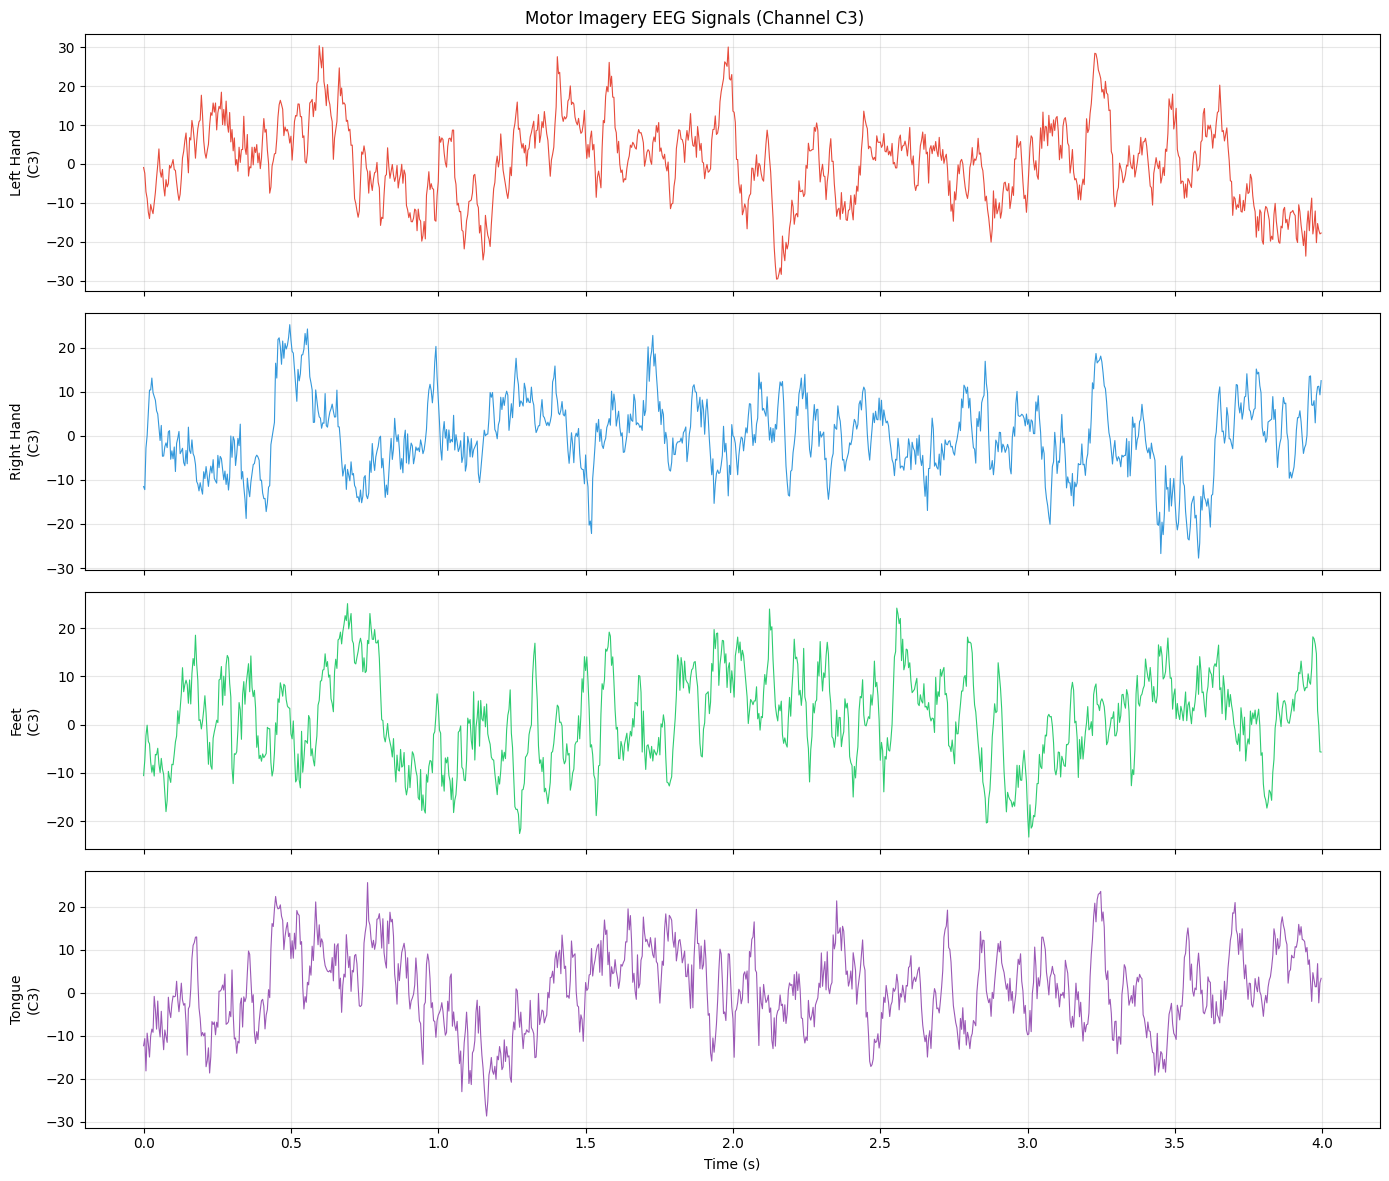

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

for class_idx, (ax, class_name) in enumerate(zip(axes, BCI_CLASS_NAMES)):
    trial_idx = np.where(labels_array == class_idx)[0][0]
    trial = bci_trials[trial_idx]

    time = np.arange(trial.shape[1]) / BCI_FS
    ax.plot(time, trial[7, :], linewidth=0.8, color=colors[class_idx])
    ax.set_ylabel(f'{class_name}\n(C3)', fontsize=10)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.suptitle('Motor Imagery EEG Signals (Channel C3)')
plt.tight_layout()
plt.show()

Dataset Preprocessing

In [ ]:
import numpy as np
import os
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def load_bci_native(data_dir):
    """Load BCI IV-2a at native 250Hz with proper preprocessing"""
    files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npz')])
    print(f"Loading {len(files)} files...")

    mi_codes = {769: 0, 770: 1, 771: 2, 772: 3}
    fs = 250  # Native sampling rate

    # Bandpass filter 4-38Hz (captures mu and beta rhythms)
    b, a = butter_bandpass(4, 38, fs, order=4)

    all_X, all_y = [], []

    for file_name in files:
        data = np.load(os.path.join(data_dir, file_name))
        signal = data['s']
        etyp = data['etyp'].flatten()
        epos = data['epos'].flatten()

        start_indices = np.where(etyp == 768)[0]

        for idx in start_indices:
            try:
                next_event = etyp[idx + 1]
                if next_event not in mi_codes:
                    continue

                class_label = mi_codes[next_event]
                trial_start = epos[idx]

                # Use 2-6s window (standard for BCI IV-2a) = 1000 samples at 250Hz
                mi_start = trial_start + int(2 * fs)  # 2 seconds after cue
                mi_end = trial_start + int(6 * fs)    # 6 seconds after cue

                trial_data = signal[mi_start:mi_end, :22].T  # (22, 1000)

                if trial_data.shape[1] < 1000:
                    continue

                # Bandpass filter
                trial_filtered = np.array([filtfilt(b, a, ch) for ch in trial_data])

                # Z-score normalization per trial
                trial_norm = (trial_filtered - trial_filtered.mean()) / (trial_filtered.std() + 1e-8)

                all_X.append(trial_norm)
                all_y.append(class_label)

            except:
                continue

    X = np.array(all_X, dtype=np.float32)
    y = np.array(all_y, dtype=np.int64)

    print(f"Data shape: {X.shape}")  # Should be (N, 22, 1000)
    print(f"Labels: {y.shape}")
    for i, name in enumerate(BCI_CLASS_NAMES):
        print(f"  {name}: {np.sum(y==i)} ({100*np.mean(y==i):.1f}%)")

    return X, y

X_bci, y_bci = load_bci_native(BCI_DATA_DIR)

Loading 18 files...
Data shape: (2328, 22, 1000)
Labels: (2328,)
  Left Hand: 572 (24.6%)
  Right Hand: 591 (25.4%)
  Feet: 574 (24.7%)
  Tongue: 591 (25.4%)


Model architecture and training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

SEED = 42
BATCH_SIZE = 32
EPOCHS = 200
N_CLASSES = 4
N_CHANNELS = 22
N_SAMPLES = 1000

torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class MotorImageryNet(nn.Module):
    def __init__(self, n_classes=4, n_channels=22, n_samples=1000,
                 F1=8, D=2, F2=16, kern_length=125, dropout=0.5):
        super().__init__()

        self.conv1 = nn.Conv2d(1, F1, (1, kern_length), padding=(0, kern_length//2), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)

        self.conv2 = nn.Conv2d(F1, F1 * D, (n_channels, 1), groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(F1 * D)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d((1, 4))
        self.drop1 = nn.Dropout(dropout)

        self.conv3 = nn.Conv2d(F1 * D, F1 * D, (1, 16), padding=(0, 8), groups=F1 * D, bias=False)
        self.conv4 = nn.Conv2d(F1 * D, F2, (1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(F2)
        self.elu2 = nn.ELU()
        self.pool2 = nn.AvgPool2d((1, 8))
        self.drop2 = nn.Dropout(dropout)

        self.flatten_size = F2 * (n_samples // 32)
        self.classifier = nn.Linear(self.flatten_size, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu1(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.elu2(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = x.flatten(1)
        x = self.classifier(x)
        return x


class BCIDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment and np.random.rand() > 0.5:
            x = x + torch.randn_like(x) * 0.1
        return x, self.y[idx]


X_train, X_test, y_train, y_test = train_test_split(
    X_bci, y_bci, test_size=0.2, random_state=SEED, stratify=y_bci
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

train_loader = DataLoader(
    BCIDataset(X_train, y_train, augment=True),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    BCIDataset(X_test, y_test, augment=False),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

model = MotorImageryNet(
    n_classes=N_CLASSES,
    n_channels=N_CHANNELS,
    n_samples=N_SAMPLES,
    F1=8, D=2, F2=16,
    kern_length=125,
    dropout=0.5
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
best_acc = 0
patience = 30
no_improve = 0

print("\nTraining MotorImageryNet")
for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    train_loss /= len(train_loader)
    train_acc = 100. * correct / total

    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            test_loss += loss.item()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    test_f1 = 100. * f1_score(all_labels, all_preds, average='weighted')

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        best_state = model.state_dict().copy()
        best_preds, best_labels = all_preds, all_labels
        no_improve = 0
    else:
        no_improve += 1

    print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {train_loss:.3f}/{test_loss:.3f} | "
          f"Acc: {train_acc:.1f}%/{test_acc:.1f}% | F1: {test_f1:.1f}%")

    if no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\nBest Accuracy: {best_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(best_labels, best_preds, target_names=BCI_CLASS_NAMES))

Train: 1862, Test: 466
Model parameters: 3932

Training MotorImageryNet
Epoch   1/200 | Loss: 1.399/1.371 | Acc: 26.5%/31.1% | F1: 30.4%
Epoch   2/200 | Loss: 1.370/1.340 | Acc: 32.2%/35.6% | F1: 33.0%
Epoch   3/200 | Loss: 1.332/1.316 | Acc: 34.1%/37.8% | F1: 35.4%
Epoch   4/200 | Loss: 1.316/1.296 | Acc: 37.2%/39.7% | F1: 37.6%
Epoch   5/200 | Loss: 1.286/1.290 | Acc: 40.3%/40.6% | F1: 38.4%
Epoch   6/200 | Loss: 1.286/1.279 | Acc: 39.5%/41.6% | F1: 39.9%
Epoch   7/200 | Loss: 1.264/1.258 | Acc: 41.5%/43.6% | F1: 41.3%
Epoch   8/200 | Loss: 1.238/1.241 | Acc: 41.9%/44.6% | F1: 43.6%
Epoch   9/200 | Loss: 1.216/1.199 | Acc: 45.5%/48.1% | F1: 47.4%
Epoch  10/200 | Loss: 1.199/1.174 | Acc: 45.4%/49.6% | F1: 48.7%
Epoch  11/200 | Loss: 1.187/1.152 | Acc: 46.8%/51.3% | F1: 50.8%
Epoch  12/200 | Loss: 1.159/1.130 | Acc: 47.7%/52.1% | F1: 51.4%
Epoch  13/200 | Loss: 1.147/1.120 | Acc: 50.0%/53.0% | F1: 52.5%
Epoch  14/200 | Loss: 1.152/1.111 | Acc: 48.9%/54.1% | F1: 53.8%
Epoch  15/200 | Lo

Results

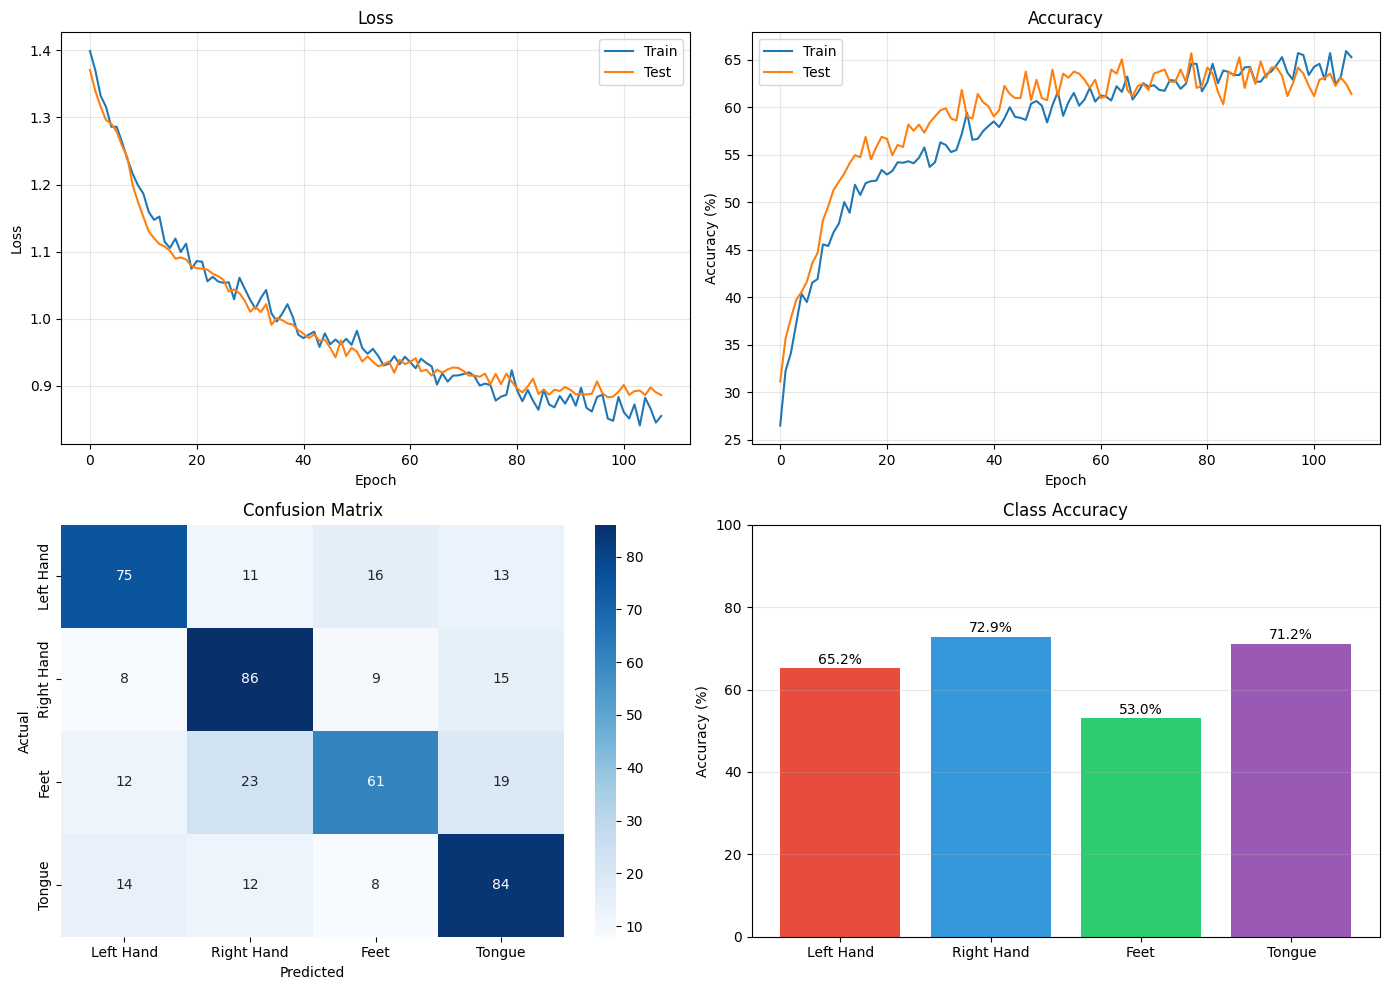

Model saved to: /content/drive/MyDrive/EEG2 - Copy/results/motor_imagery_model.pth


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['test_loss'], label='Test')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['train_acc'], label='Train')
axes[0, 1].plot(history['test_acc'], label='Test')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

cm = confusion_matrix(best_labels, best_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=BCI_CLASS_NAMES, yticklabels=BCI_CLASS_NAMES, ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix')

class_acc = cm.diagonal() / cm.sum(axis=1) * 100
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
bars = axes[1, 1].bar(BCI_CLASS_NAMES, class_acc, color=colors)
for bar, acc in zip(bars, class_acc):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{acc:.1f}%', ha='center', fontsize=10)
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Class Accuracy')
axes[1, 1].set_ylim(0, 100)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

save_dir = '/content/drive/MyDrive/EEG2 - Copy/results'
os.makedirs(save_dir, exist_ok=True)
motor_path = os.path.join(save_dir, 'motor_imagery_model.pth')
torch.save(best_state, motor_path)
print(f"Model saved to: {motor_path}")